### Basic SQL Agent

Levels of basic SQL agents. The goal here is starting with basic prompting + access to SQL/code working. Then add in more CoT before getting a more advanced cognitive architecture. The goal here is essentially if there is a user query that I could have answered in say less than an hour using the resources the LLM was given, it should be able to as well. In other words, the data and query must be coherent, with that being the only real requirement. 

The design here is purposely incredibly minimal. For example, there is no error handling, advanced logic, or really anything else. 

In [51]:
import os 
import time
import json
from dotenv import load_dotenv 

import re 
import numpy as np 
import pandas as pd

from sqlalchemy import create_engine
from langchain_openai import ChatOpenAI 
from langchain_community.utilities import SQLDatabase

class Config:
    """SQL agent config"""
    def __init__(
        self,
        env_fpath,
        sql_db_fpath,
        openai_model = 'gpt-4-1106-preview',
        temperature  = 0.7
        ):
        load_dotenv(env_fpath)
        openai_api_key = os.getenv("OPENAI_API_KEY")
        
        self.llm = ChatOpenAI(
            model=openai_model,
            temperature=temperature,
            api_key=openai_api_key
            )
        self.db = SQLDatabase.from_uri(f"sqlite:///{sql_db_fpath}")
        self.engine = create_engine(f"sqlite:///{sql_db_fpath}")

In [15]:
SRC_PATH     = os.path.dirname(os.getcwd())
ENV_FPATH    = f'{SRC_PATH}/keys.env'
SQL_DB_FPATH = f'{SRC_PATH}/synthetic_data.db' 

print(f'src path: {SRC_PATH}')
print(f'env fpath: {ENV_FPATH}')
print(f'sql db fpath: {SQL_DB_FPATH}')

config = Config(
    env_fpath    = ENV_FPATH,
    sql_db_fpath = SQL_DB_FPATH  
    )   

src path: /Users/jcheigh/text2sql/src
env fpath: /Users/jcheigh/text2sql/src/keys.env
sql db fpath: /Users/jcheigh/text2sql/src/synthetic_data.db


### Agent 1 Logic

This agent will take the user query, generate/execute sql to pull the relevant data, and then generate/execute python code to return the desired result. Below will show the system prompts/a labeled user query/desired behavior. The actual system prompts will include this one shot example.

For now, we will stick to the basics, both in terms of user query complexity and agent complexity:
- Users will ask basic data analytics about relevant tables, with very clear instructions
- Our system will have essentially no error handling 
- Our system will have no CoT or an advanced cognitive architecture. 

*User Query:* Calculate the correlation between 7 year treasury yields and stocks close over the last 30 days in the table. 

**Step 1- SQL Query**

*System Prompt:* 
    
Given a user query, generate a syntatically correct SQLite query wrapped in ```sql {QUERY}``` that pulls all the data relevant to the query. Do not perform any computation, assume that the user is able to take the raw data and perform the relevant computations to reach the desired result. Be mindful of how many days of data to pull, as certain queries may specific n days but require more than n to compute the result. Make sure the column names in the resulting table are clear. Here is the database schema: {schema_context} 

*Labeled Answer:*
``` sql 
SELECT 
    y.date AS date,
    y.yield_7_year AS treasury_yield_7_year,
    o.close AS stock_close
FROM 
    treasury_yields y
INNER JOIN 
    ohlc o ON y.date = o.date
ORDER BY 
    y.date DESC
LIMIT 30;
```

*Result of Executing SQL:*

| Date                | Treasury Yield (7-Year) | Stock Close   |
|---------------------|--------------------------|---------------|
| 2024-01-01 00:00:00 | 4.113933                | 84.676268     |
| 2023-12-29 00:00:00 | 4.117221                | 100.393128    |
| 2023-12-28 00:00:00 | 2.391113                | 112.975980    |
| 2023-12-27 00:00:00 | 1.482054                | 119.224503    |
| 2023-12-26 00:00:00 | 4.187207                | 108.335695    |

**Step 2- Generate Python Code**

*System Prompt:* 
    
Given a user query and a pandas dataframe with the relevant data, generate syntatically correct python code wrapped in ```python {QUERY}`` that takes the raw dataframe and performs any computations to fully answer the user's query. Assume access to NumPy (v1.26.4), Pandas (v2.2.3) and that the dataframe is called df. The output of the code should be the variable that contains the result of the user's query.
*Labeled Answer:*
``` python

### calculate corr btwn 7yr tsy and stock closes 
corr = df['treasury_yield_7_year'].corr(df['stock_close'])
### output the variable that stores the result of the user's query
corr 
```
*Result of Executing Python:* 
-0.21388019833929192


In [16]:
def get_schema_context(config):
    db     = config.db
    tables = db.get_usable_table_names()

    schema_lines = []
    for table in tables:
        if table in ['ohlc', 'treasury_yields']:
            table_info = db.get_table_info([table])
            schema_lines.append(f"Table: {table}\n{table_info}\n")

    schema_context = (
    "DATABASE SCHEMA:\n" +
    "\n".join(schema_lines)
    )
    return schema_context

def extract_query(response: str, sql=True) -> str:
    pattern = r'```sql\n(.*?)\n```' if sql else r'```python\n(.*?)\n```'
    matches = re.findall(pattern, response, re.DOTALL)
    if matches:
        return matches[0].strip()
    
    print(f'Extracting Query Failed: returning response.strip(): \n {response.strip()}')
    ### if no matches
    return response.strip()

In [23]:
def execute_sql1(user_query, config):
    """generate and execute sql"""
    schema_context = get_schema_context(config)
    sql_prompt     = f''' 
    Given a user query, generate a single syntatically correct SQLite query wrapped in ```sql QUERY``` that pulls all the 
    data relevant to the query. Do not perform any computation, assume that the user is able to take the raw data and 
    perform the relevant computations to reach the desired result. Be mindful of how many days of data to pull, as 
    certain queries may specific n days but require more than n to compute the result. For days do LIMIT rather than now().
    Make sure the column names in the resulting table are clear. Here is the database schema: {schema_context}
    Here is an example user query and then correct output:

    User Query: Calculate the correlation between 7 year treasury yields and stocks close over the last 30 days in the table.
    Correct Output: ``` sql 
    SELECT 
        y.date AS date,
        y.yield_7_year AS treasury_yield_7_year,
        o.close AS stock_close
    FROM 
        treasury_yields y
    INNER JOIN 
        ohlc o ON y.date = o.date
    ORDER BY 
        y.date DESC
    LIMIT 30;
    ```
    Notice there is no calculation calculation. This is the correct response, as 
    the correlation will be calculated later.
    
    Give the correct output for user query: {user_query}
    '''
    sql_query = extract_query(config.llm.invoke(sql_prompt).content)
    print(f'SQL Query: {sql_query}')
    df = pd.read_sql(sql_query, config.engine)
    df.head()
    return df 

def execute_python1(user_query, df, config):
    """generate and execute python"""
    python_prompt = f''' 
    Given a user query and a pandas dataframe with the relevant data, generate syntatically correct python code 
    wrapped in ```python QUERY`` that takes the raw dataframe and performs any computations to fully answer the 
    user's query. Assume access to NumPy (v1.26.4), Pandas (v2.2.3) and that the dataframe is called df. The output 
    variable should always be called result. 

    Here is an example user query and df and then correct output:

    User Query: Calculate the correlation between 7 year treasury yields and stocks close over the last 30 days
    in the table.
    Dataframe (df): 
    Date,Treasury Yield (7-Year),Stock Close
    2024-01-01 00:00:00,4.113933,84.676268
    2023-12-29 00:00:00,4.117221,100.393128
    2023-12-28 00:00:00,2.391113,112.97598
    2023-12-27 00:00:00,1.482054,119.224503
    2023-12-26 00:00:00,4.187207,108.335695

    *Labeled Answer:*
    ``` python

    ### calculate corr btwn 7yr tsy and stock closes 
    result = df['treasury_yield_7_year'].corr(df['stock_close'])
    ```

    User Query: \n{user_query}
    df.head: \n{df.head()}
    '''

    code = extract_query(config.llm.invoke(python_prompt).content, sql=False)
    print(f'Python Code:\n {code}')
    
    namespace = {'pd': pd, 'np': np, 'df': df}
    exec(code, namespace)
    result = namespace.get('result', "No result variable found")
    print(f'Result:\n{result}')
    return result 

def run_agent1(user_query, config=config):
    """main function to run agent 1"""
    print(f'User Query:\n {user_query}')
    start  = time.time()
    df     = execute_sql1(user_query, config)
    result = execute_python1(user_query, df, config)
    end    = time.time()

    print(f'runtime: {round(end-start,2)} seconds')
    return result

In [5]:
user_query = '''
Calculate the standard deviation of range := high of stocks - low of stocks over 30 days as well as the 
standard deviation of 5s10s := 10y tsy yield - 5y tsy yield over the same 30 days. Give me the absolute 
value between these 2 standard deviations. 
''' 
result = run_agent1(user_query)

User Query:
 
Calculate the standard deviation of range := high of stocks - low of stocks over 30 days as well as the 
standard deviation of 5s10s := 10y tsy yield - 5y tsy yield over the same 30 days. Give me the absolute 
value between these 2 standard deviations. 

SQL Query: SELECT 
    o.date AS date,
    o.high - o.low AS stock_range,
    t.yield_10_year - t.yield_5_year AS treasury_5s10s
FROM 
    ohlc o
INNER JOIN 
    treasury_yields t ON o.date = t.date
ORDER BY 
    o.date DESC
LIMIT 30;
Python Code:
 # Calculate the standard deviation of stock_range and treasury_5s10s over 30 days
std_stock_range = df['stock_range'].std()
std_treasury_5s10s = df['treasury_5s10s'].std()

# Calculate the absolute difference between the two standard deviations
result = abs(std_stock_range - std_treasury_5s10s)
Result:
5.310255348485894
Run Time: 4.63


In [12]:
user_query = '''Find the days where stock price movement := close-open was more 
than 2 standard deviations from the mean'''
result     = run_agent1(user_query)

User Query:
 Find the days where stock price movement := close-open was more 
than 2 standard deviations from the mean
SQL Query: SELECT 
    date,
    close - open AS price_movement,
    open,
    close
FROM 
    ohlc;
Python Code:
 ### find days where price movement was more than 2 std from the mean
mean_price_movement = df['price_movement'].mean()
std_price_movement = df['price_movement'].std()
threshold = 2 * std_price_movement
result = df[abs(df['price_movement'] - mean_price_movement) > threshold]
Result:
                    date  price_movement        open       close
81   2020-04-23 00:00:00      -37.622879  119.805352   82.182473
93   2020-05-11 00:00:00       38.642258   75.185920  113.828178
113  2020-06-08 00:00:00       42.611805   76.177284  118.789089
133  2020-07-06 00:00:00      -36.881398  119.820372   82.938974
146  2020-07-23 00:00:00       41.814494   76.254379  118.068873
284  2021-02-02 00:00:00       38.902059   76.743447  115.645506
306  2021-03-04 00:00:00    

### Agent 2 Logic

The expected workflow for agent 1 is to not perform any computation in the SQL step, leaving this to the code interpreter. However, here the SQL query generation has at context the original user query, which means to answer correctly it must (a) determine the relevant data and (b) query that data without additional computation. It seems to have trouble with this, always performing computation on its own. This next agent will make these two steps separated.


*User Query:* Calculate the correlation between 7 year treasury yields and stocks close over the last 30 days in the table. 

**Step 1- Parse SQL Content**

*System Prompt:* 

Given a user query and a SQlite db schema, only write QUERY DESCRIPTION: {QUERY DESCRIPTION}, where QUERY DESCRIPTION is a prompt that describes the query (table, cols, new col name, filters, joins, etc.) to get the raw data necessary to answer this user query. Don't write any code or explain any computation, but write the prompt such that if an independent SQL master with access to the SQlite db + schema + your instructions could easily query the data.

Be mindful of how many days of data to pull, as certain queries may specific n days but require more than n to compute the result.  Make sure the column names in the resulting table are clear. 

Database Schema: {schema_context}

*Labeled Answer:*
QUERY DESCRIPTION:
Tables Involved:
- ohlc (Stock data with date and close price)
- treasury_yields (Treasury yields with 7-year yield and date)
Columns Required: 
- from ohlc: date, close (rename stock_close)
- from treasury_yields: date, yield_7_year (rename -tsy_yield_7_year)
Filters: 
- only consider the last 30 days of data in the table. 
Joins: 
- perform an inner join between ohlc and treasury_yields on the date column to align stock data with treasury yields.

**Step 2- SQL Query:**

*System Prompt:*

Given a SQlite db schema and a query description generate a syntatically correct SQLite query wrapped in ```sql {QUERY}``` that pulls all the data relevant to the query.

Database Schema: {schema_context} 

*Labeled Answer:*
``` sql 
SELECT 
    y.date AS date,
    y.yield_7_year AS treasury_yield_7_year,
    o.close AS stock_close
FROM 
    treasury_yields y
INNER JOIN 
    ohlc o ON y.date = o.date
ORDER BY 
    y.date DESC
LIMIT 30;
```

*Result of Executing SQL:*

| Date                | Treasury Yield (7-Year) | Stock Close   |
|---------------------|--------------------------|---------------|
| 2024-01-01 00:00:00 | 4.113933                | 84.676268     |
| 2023-12-29 00:00:00 | 4.117221                | 100.393128    |
| 2023-12-28 00:00:00 | 2.391113                | 112.975980    |
| 2023-12-27 00:00:00 | 1.482054                | 119.224503    |
| 2023-12-26 00:00:00 | 4.187207                | 108.335695    |

**Step 3- Parse Python Content**

*System Prompt:* 
    
Given a user query and a pandas dataframe with the relevant data, only write CODE DESCRIPTION: {CODE DESCRIPTION}, where CODE DESCRIPTION is a prompt that describes how to take the dataframe (called df)
and write python code to perform relevant computations to answer the user query. Don't write any code, 
but write the prompt such that if an independent python master with access to df + your instructions could 
easily answer the original user query. Be specific about how to perform the computations, including any 
relevant math, what functions to use (assume pandas, numpy access). 

*Labeled Answer:*

CODE DESCRIPTION: Given df with cols treasury_yield_7_year, stock_close, date, use pandas corr function
to compute the correlation between treasury_yield_7_year and stock close. 


**Step 4- Python Code:**

*System Prompt:*

Given a pandas dataframe df and a description to perform a specific computation, generate syntatically correct python code wrapped in ```python {QUERY}`` that takes the raw dataframe and performs any computations to fully answer the user's query. Assume access to NumPy (v{np.__version__}), Pandas (v{pd.__version__}) and that the dataframe is called df. The output of the code should be the variable that contains the result of the user's query (call this variable result)

df.head: {df.head()}

*Labeled Answer:*
``` python
### calculate corr btwn 7yr tsy and stock closes 
corr = df['treasury_yield_7_year'].corr(df['stock_close'])
### output the variable that stores the result of the user's query
corr 
```
*Result of Executing Python:* 
-0.21388019833929192


In [49]:
def run_agent2(user_query, config=config):
    """main function to run agent 2"""
    print(f'User Query:\n {user_query}')
    start      = time.time()
    sql_prompt = get_sql_prompt2(user_query, config)
    df         = execute_sql2(sql_prompt, config)
    py_prompt  = get_python_prompt2(user_query, df, config)
    result     = execute_python2(py_prompt, df, config)
    end        = time.time()

    print(f'runtime: {round(end-start,2)} seconds')
    return result

def get_sql_prompt2(user_query, config):
    schema_context = get_schema_context(config)
    prompt         = f'''Given a user query and a SQlite db schema, only write 
    QUERY DESCRIPTION: QUERY DESCRIPTION, where QUERY DESCRIPTION is a prompt that 
    describes the query (table, cols, new col name, joins, etc.) to get the 
    raw data necessary to answer this user query. Don't write any code or explain any 
    computation, but write the prompt such that if an independent SQL master with access 
    to the SQlite db + schema + your instructions could easily query the data.

    Be mindful of how many days of data to pull, as certain queries may specific n days but 
    require more than n to compute the result.  Make sure the column names in the resulting 
    table are clear. 

    Database Schema: {schema_context}

    Example User Query: Calculate the correlation between 7 year treasury yields and stocks 
    close over the last 30 days in the table. 

    Example Labeled Answer:
    QUERY DESCRIPTION:
        Tables Involved:
        - ohlc (Stock data with date and close price)
        - treasury_yields (Treasury yields with 7-year yield and date)
        Columns Required: 
        - from ohlc: date, close (rename stock_close)
        - from treasury_yields: date, yield_7_year (rename -tsy_yield_7_year)
        Filters: 
        - only consider the last 30 days of data in the table. 
        Joins: 
        - perform an inner join between ohlc and treasury_yields on the date column to 
        align stock data with treasury yields.

    Note that the correlation is not calculated here. The prompt should NOT include
    any math. no standard deviation, no avg, nothing more advanced than multiplication. DO NOT MAKE
    ANY NEW COLUMNS. SAY THAT CALCULATIONS WILL BE DONE LATER, BY THE MATH MASTER. No filters,
    this will be done later by the FILTER MASTER.
    
    User Query: {user_query}
    '''
    sql_prompt = config.llm.invoke(prompt).content
    print(f'Generated SQL Promp: {sql_prompt}')
    return sql_prompt

def execute_sql2(sql_prompt, config):
    """generate and execute sql"""
    schema_context = get_schema_context(config)
    sql_prompt     = f''' 
    Given a SQlite db schema and a query description, generate a syntatically correct SQLite
     query wrapped in ```sql QUERY``` that pulls all the data relevant to the query.

    Database Schema: {schema_context} 

    Example Input Prompt: 
    QUERY DESCRIPTION:
    Tables Involved:
    - ohlc (Stock data with date and close price)
    - treasury_yields (Treasury yields with 7-year yield and date)
    Columns Required: 
    - from ohlc: date, close (rename stock_close)
    - from treasury_yields: date, yield_7_year (rename tsy_yield_7_year) 
    Joins: 
    - perform an inner join between ohlc and treasury_yields on the date column to align 
    stock data with treasury yields.

    *Labeled Answer:*
    ``` sql 
    SELECT 
        y.date AS date,
        y.yield_7_year AS treasury_yield_7_year,
        o.close AS stock_close
    FROM 
        treasury_yields y
    INNER JOIN 
        ohlc o ON y.date = o.date
    ORDER BY 
        y.date DESC
    
    Input Prompt: {sql_prompt}
    '''
    sql_query = extract_query(config.llm.invoke(sql_prompt).content)
    print(f'SQL Query: {sql_query}')
    df = pd.read_sql(sql_query, config.engine)
    df.head()
    return df 

def get_python_prompt2(user_query, df, config):
    prompt = f''' 
    Given a user query and a pandas dataframe with the relevant data, only write 
    CODE DESCRIPTION: CODE DESCRIPTION, where CODE DESCRIPTION is a prompt that 
    describes how to take the dataframe (called df) and write python code to perform 
    relevant computations to answer the user query. Don't write any code, but write 
    the prompt such that if an independent python master with access to df + your instructions could 
    easily answer the original user query. Be specific about how to perform the computations,
    including any relevant math, what functions to use (assume pandas, numpy access). 

    Example User Query: Calculate the correlation between 7 year treasury yields and stocks close over the last 30 days
    in the table.
    Example Dataframe (df.head()): 
    Date,Treasury Yield (7-Year),Stock Close
    2024-01-01 00:00:00,4.113933,84.676268
    2023-12-29 00:00:00,4.117221,100.393128
    2023-12-28 00:00:00,2.391113,112.97598
    2023-12-27 00:00:00,1.482054,119.224503
    2023-12-26 00:00:00,4.187207,108.335695

    Example Answer:
    CODE DESCRIPTION: Given df with cols treasury_yield_7_year, stock_close, date, use pandas corr function
    to compute the correlation between treasury_yield_7_year and stock close over the most recent 30 days.

    df.head(): {df.head()}
    User Query: {user_query}
    '''
    py_prompt = config.llm.invoke(prompt).content
    print(f'Generated Python Prompt: {py_prompt}')
    return py_prompt

def execute_python2(py_prompt, df, config):
    """generate and execute python"""
    py_code = f''' 
    Given a pandas dataframe df and a description to perform a specific computation, 
    generate syntatically correct python code wrapped in ```python QUERY`` that takes 
    the raw dataframe and performs any computations to fully answer the user's query. 
    Assume access to NumPy (v{np.__version__}), Pandas (v{pd.__version__}) and that 
    the dataframe is called df. The output of the code should be the variable that 
    contains the result of the user's query (call this variable result)

    Example Dataframe (df): 
    Date,Treasury Yield (7-Year),Stock Close
    2024-01-01 00:00:00,4.113933,84.676268
    2023-12-29 00:00:00,4.117221,100.393128
    2023-12-28 00:00:00,2.391113,112.97598
    2023-12-27 00:00:00,1.482054,119.224503
    2023-12-26 00:00:00,4.187207,108.335695

    Example Prompt: Given df with cols treasury_yield_7_year, stock_close, date, use pandas corr function
    to compute the correlation between treasury_yield_7_year and stock close. 

    Example Labeled Answer: 
    ``` python
    ### calculate corr btwn 7yr tsy and stock closes 
    df     = df.sort_values('date')[:30]
    result = df['treasury_yield_7_year'].corr(df['stock_close'])
    ```
    df.head(): {df.head()}
    Prompt: {py_prompt}
    '''
    code = extract_query(config.llm.invoke(py_code).content, sql=False)
    print(f'Python Code:\n {code}')
    
    namespace = {'pd': pd, 'np': np, 'df': df}
    exec(code, namespace)
    result = namespace.get('result', "No result variable found")
    print(f'Result:\n{result}')
    return result 

In [42]:
user_query = '''Find the days where stock price movement := close-open was more 
than 2 standard deviations from the mean'''
result     = run_agent2(user_query)

User Query:
 Find the days where stock price movement := close-open was more 
than 2 standard deviations from the mean
Generated SQL Promp: QUERY DESCRIPTION:
    Tables Involved:
    - ohlc (Stock data with open and close prices and date)

    Columns Required:
    - from ohlc: date, open, close

    Additional Instructions:
    - Pull all available data from the ohlc table as the mean and standard deviation calculations will be handled later by the MATH MASTER. No filters or calculations should be applied to the data at this stage.
SQL Query: SELECT 
    date, 
    open, 
    close
FROM 
    ohlc
Generated Python Prompt: CODE DESCRIPTION: First, calculate the stock price movement by subtracting the 'open' column from the 'close' column, and add this as a new column 'price_movement' in df. Then, calculate the mean and standard deviation of the 'price_movement' column. After that, determine the threshold for price movements that are more than 2 standard deviations from the mean by addi

In [43]:
user_query = '''For s in [1,2,3], of the days where the stock price 
movement := close - open was more than s std deviations from the mean, 
find the 25p, 50p, 75p (25th percentile etc.) of 7y tsy yield - 5y tsy yield. 
Compile these results in a table. 
'''
result     = run_agent2(user_query)

User Query:
 For s in [1,2,3], of the days where the stock price 
movement := close - open was more than s std deviations from the mean, 
find the 25p, 50p, 75p (25th percentile etc.) of 7y tsy yield - 5y tsy yield. 
Compile these results in a table. 

Generated SQL Promp: QUERY DESCRIPTION:
Tables Involved:
- ohlc (Stock data with date, open, and close prices)
- treasury_yields (Treasury yields with 5-year, 7-year yields and date)
Columns Required: 
- from ohlc: date, open, close (rename stock_open, stock_close)
- from treasury_yields: date, yield_5_year (rename tsy_yield_5_year), yield_7_year (rename tsy_yield_7_year)
Joins: 
- perform an inner join between ohlc and treasury_yields on the date column to align stock data with treasury yields.
Additional Notes:
- The calculation of stock price movement (stock_close - stock_open) and the difference between 7y and 5y treasury yields (tsy_yield_7_year - tsy_yield_5_year) will be performed by the Math Master.
- The identification of days w

<string>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


User Query:
 For s in [1,2], of the days where the stock price 
movement := close - open was more than s std deviations from the mean, look at the distribution 
of 7yr tsy yield - 5yr tsy yield. To visualize this, assume access to matplotlib.pyplot as plt and 
make a 2 plots, the left where s = 1 and a histogram of 7yr - 5yr tsy yields with lines at 25 percentile,
50th percentile, 75th, and then right same with s=2

Generated SQL Promp: QUERY DESCRIPTION:
    Tables Involved:
    - ohlc (Stock data with date, open, and close price)
    - treasury_yields (Treasury yields with 5-year and 7-year yields and date)
    Columns Required: 
    - from ohlc: date, open, close (rename open as stock_open, rename close as stock_close)
    - from treasury_yields: date, yield_5_year, yield_7_year
    New Column Names:
    - stock_open: stock_open
    - stock_close: stock_close
    - yield_5_year: tsy_yield_5_year
    - yield_7_year: tsy_yield_7_year
    Joins: 
    - perform an inner join between ohl

<string>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


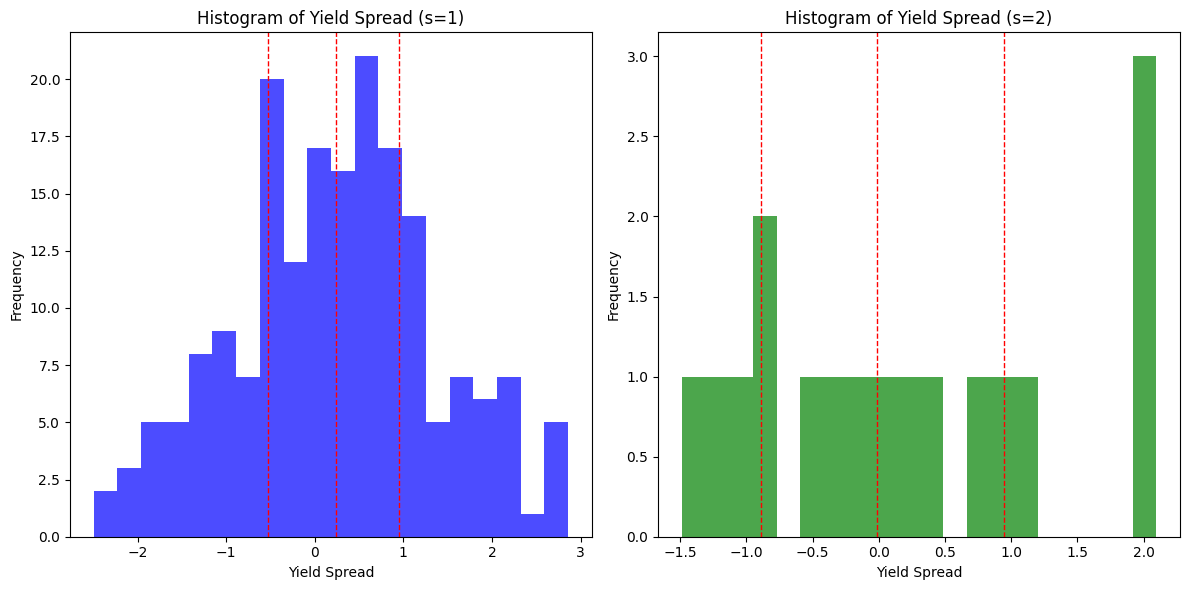

Result:
(                     date  stock_open  stock_close  tsy_yield_5_year  \
2     2020-01-03 00:00:00   80.588951   114.299401          3.956148   
10    2020-01-15 00:00:00   92.603017   119.438206          2.630673   
15    2020-01-22 00:00:00   83.217818   109.957597          3.495434   
21    2020-01-30 00:00:00   91.323475   114.125489          3.986782   
27    2020-02-07 00:00:00   88.821117   114.122679          4.006582   
...                   ...         ...          ...               ...   
1029  2023-12-12 00:00:00   95.791060   117.099387          2.348880   
1031  2023-12-14 00:00:00   83.611933   104.680075          1.393706   
1033  2023-12-18 00:00:00   79.004995   103.303427          3.844049   
1034  2023-12-19 00:00:00   88.607451   115.991586          1.779953   
1040  2023-12-27 00:00:00   84.676598   119.224503          1.320941   

      tsy_yield_7_year  stock_movement  yield_spread  
2             3.533201       33.710450     -0.422947  
10            1.

In [48]:
import matplotlib.pyplot as plt 

user_query = '''For s in [1,2], of the days where the stock price 
movement := close - open was more than s std deviations from the mean, look at the distribution 
of 7yr tsy yield - 5yr tsy yield. To visualize this, assume access to matplotlib.pyplot as plt and 
make a 2 plots, the left where s = 1 and a histogram of 7yr - 5yr tsy yields with lines at 25 percentile,
50th percentile, 75th, and then right same with s=2
'''
result     = run_agent2(user_query)


### Agent 3 Logic

Ok, it's pretty good at this point. The SQL prompt generation is a bit finicky, but if we break this down a bit more it'll be a good start.


Given user query, give it to the plan master who will return a json with info on SQL query (tables, columns, joins, new names, etc.), python steps (step by step)



table -> (column, new name), ...
join : (table 1, table 1 on, table 2, table 2 on, type)


In [52]:
def run_agent3(user_query, config=config):
    """main function to run agent 2"""
    print(f'User Query:\n {user_query}')
    start      = time.time()
    sql_json   = get_sql_json3(user_query, config)
    sql_prompt = sql_json_to_prompt3(sql_json)
    df         = execute_sql3(sql_prompt, config)
    py_prompt  = get_python_prompt3(user_query, df, config)
    result     = execute_python3(py_prompt, df, config)
    end        = time.time()

    print(f'runtime: {round(end-start,2)} seconds')
    return result

def get_sql_json3(user_query, config):
    schema_context = get_schema_context(config)
    
    # construct the prompt
    prompt = f'''Given a user query and a SQLite database schema, return a JSON describing the 
    data required to answer the user query. Write the prompt such that if an independent SQL 
    master with access to the SQLite database schema and your instructions could easily query the data.

    Be mindful of how many days of data to pull, as certain queries may specify n days but 
    require more than n to compute the result. Make sure the column names in the resulting 
    table are clear. Avoid creating new columns or performing calculations, as these will 
    be handled in later steps.

    Ensure the new column names are self-explanatory and clear.

    Answer with a JSON in this format:
        {{
            "tables": {{
                "table1": [("original_column_name", "new_column_name"), ...],
                "table2": [...]
            }},
            "joins": [
                ("tableA", "tableB", "tableA_join_column", "tableB_join_column", "join_type")
            ]
        }}

    Constraints:
    - Join types must be one of: inner, left, right, outer.
    - JSON must be valid and parsable.

    Database Schema: {schema_context}

    Example User Query: Calculate the correlation between 7-year treasury yields and stocks' 
    close prices over the last 30 days.

    Example Labeled Answer:
        {{
            "tables": {{
                "ohlc": [("date", "date"), ("close", "stock_close")],
                "treasury_yields": [("date", "date"), ("yield_7_year", "tsy_yield_7_year")]
            }},
            "joins": [
                ("ohlc", "treasury_yields", "date", "date", "inner")
            ]
        }}

    User Query: {user_query}
    '''
    llm_response = config.llm.invoke(prompt).content
    print(f'LLM Response: {llm_response}')
    try:
        sql_json = json.loads(llm_response)
        
        print(f'SQL JSON: {sql_json}')
        valid_join_types = {"inner", "left", "right", "outer"}
        for join in sql_json.get("joins", []):
            if len(join) != 5 or join[-1] not in valid_join_types:
                raise ValueError(f"Invalid join type or structure: {join}")

        return sql_json
    except json.JSONDecodeError:
        raise ValueError("LLM response is not valid JSON.")
    except Exception as e:
        raise ValueError(f"Error validating SQL JSON: {e}")


def sql_json_to_prompt(sql_json):

    pass

def get_sql_prompt(user_query, config):
    schema_context = get_schema_context(config)
    prompt         = f'''Given a user query and a SQlite db schema, only write 
    QUERY DESCRIPTION: QUERY DESCRIPTION, where QUERY DESCRIPTION is a prompt that 
    describes the query (table, cols, new col name, joins, etc.) to get the 
    raw data necessary to answer this user query. Don't write any code or explain any 
    computation, but write the prompt such that if an independent SQL master with access 
    to the SQlite db + schema + your instructions could easily query the data.

    Be mindful of how many days of data to pull, as certain queries may specific n days but 
    require more than n to compute the result.  Make sure the column names in the resulting 
    table are clear. 

    Database Schema: {schema_context}

    Example User Query: Calculate the correlation between 7 year treasury yields and stocks 
    close over the last 30 days in the table. 

    Example Labeled Answer:
    QUERY DESCRIPTION:
        Tables Involved:
        - ohlc (Stock data with date and close price)
        - treasury_yields (Treasury yields with 7-year yield and date)
        Columns Required: 
        - from ohlc: date, close (rename stock_close)
        - from treasury_yields: date, yield_7_year (rename -tsy_yield_7_year)
        Filters: 
        - only consider the last 30 days of data in the table. 
        Joins: 
        - perform an inner join between ohlc and treasury_yields on the date column to 
        align stock data with treasury yields.

    Note that the correlation is not calculated here. The prompt should NOT include
    any math. no standard deviation, no avg, nothing more advanced than multiplication. DO NOT MAKE
    ANY NEW COLUMNS. SAY THAT CALCULATIONS WILL BE DONE LATER, BY THE MATH MASTER. No filters,
    this will be done later by the FILTER MASTER.
    
    User Query: {user_query}
    '''
    sql_prompt = config.llm.invoke(prompt).content
    print(f'Generated SQL Promp: {sql_prompt}')
    return sql_prompt

def execute_sql2(sql_prompt, config):
    """generate and execute sql"""
    schema_context = get_schema_context(config)
    sql_prompt     = f''' 
    Given a SQlite db schema and a query description, generate a syntatically correct SQLite
     query wrapped in ```sql QUERY``` that pulls all the data relevant to the query.

    Database Schema: {schema_context} 

    Example Input Prompt: 
    QUERY DESCRIPTION:
    Tables Involved:
    - ohlc (Stock data with date and close price)
    - treasury_yields (Treasury yields with 7-year yield and date)
    Columns Required: 
    - from ohlc: date, close (rename stock_close)
    - from treasury_yields: date, yield_7_year (rename tsy_yield_7_year) 
    Joins: 
    - perform an inner join between ohlc and treasury_yields on the date column to align 
    stock data with treasury yields.

    *Labeled Answer:*
    ``` sql 
    SELECT 
        y.date AS date,
        y.yield_7_year AS treasury_yield_7_year,
        o.close AS stock_close
    FROM 
        treasury_yields y
    INNER JOIN 
        ohlc o ON y.date = o.date
    ORDER BY 
        y.date DESC
    
    Input Prompt: {sql_prompt}
    '''
    sql_query = extract_query(config.llm.invoke(sql_prompt).content)
    print(f'SQL Query: {sql_query}')
    df = pd.read_sql(sql_query, config.engine)
    df.head()
    return df 

def get_python_prompt(user_query, df, config):
    prompt = f''' 
    Given a user query and a pandas dataframe with the relevant data, only write 
    CODE DESCRIPTION: CODE DESCRIPTION, where CODE DESCRIPTION is a prompt that 
    describes how to take the dataframe (called df) and write python code to perform 
    relevant computations to answer the user query. Don't write any code, but write 
    the prompt such that if an independent python master with access to df + your instructions could 
    easily answer the original user query. Be specific about how to perform the computations,
    including any relevant math, what functions to use (assume pandas, numpy access). 

    Example User Query: Calculate the correlation between 7 year treasury yields and stocks close over the last 30 days
    in the table.
    Example Dataframe (df.head()): 
    Date,Treasury Yield (7-Year),Stock Close
    2024-01-01 00:00:00,4.113933,84.676268
    2023-12-29 00:00:00,4.117221,100.393128
    2023-12-28 00:00:00,2.391113,112.97598
    2023-12-27 00:00:00,1.482054,119.224503
    2023-12-26 00:00:00,4.187207,108.335695

    Example Answer:
    CODE DESCRIPTION: Given df with cols treasury_yield_7_year, stock_close, date, use pandas corr function
    to compute the correlation between treasury_yield_7_year and stock close over the most recent 30 days.

    df.head(): {df.head()}
    User Query: {user_query}
    '''
    py_prompt = config.llm.invoke(prompt).content
    print(f'Generated Python Prompt: {py_prompt}')
    return py_prompt

def execute_python2(py_prompt, df, config):
    """generate and execute python"""
    py_code = f''' 
    Given a pandas dataframe df and a description to perform a specific computation, 
    generate syntatically correct python code wrapped in ```python QUERY`` that takes 
    the raw dataframe and performs any computations to fully answer the user's query. 
    Assume access to NumPy (v{np.__version__}), Pandas (v{pd.__version__}) and that 
    the dataframe is called df. The output of the code should be the variable that 
    contains the result of the user's query (call this variable result)

    Example Dataframe (df): 
    Date,Treasury Yield (7-Year),Stock Close
    2024-01-01 00:00:00,4.113933,84.676268
    2023-12-29 00:00:00,4.117221,100.393128
    2023-12-28 00:00:00,2.391113,112.97598
    2023-12-27 00:00:00,1.482054,119.224503
    2023-12-26 00:00:00,4.187207,108.335695

    Example Prompt: Given df with cols treasury_yield_7_year, stock_close, date, use pandas corr function
    to compute the correlation between treasury_yield_7_year and stock close. 

    Example Labeled Answer: 
    ``` python
    ### calculate corr btwn 7yr tsy and stock closes 
    df     = df.sort_values('date')[:30]
    result = df['treasury_yield_7_year'].corr(df['stock_close'])
    ```
    df.head(): {df.head()}
    Prompt: {py_prompt}
    '''
    code = extract_query(config.llm.invoke(py_code).content, sql=False)
    print(f'Python Code:\n {code}')
    
    namespace = {'pd': pd, 'np': np, 'df': df}
    exec(code, namespace)
    result = namespace.get('result', "No result variable found")
    print(f'Result:\n{result}')
    return result 

In [53]:
get_sql_json3('''For s in [1,2], of the days where the stock price 
movement := close - open was more than s std deviations from the mean, look at the distribution 
of 7yr tsy yield - 5yr tsy yield. To visualize this, assume access to matplotlib.pyplot as plt and 
make a 2 plots, the left where s = 1 and a histogram of 7yr - 5yr tsy yields with lines at 25 percentile,
50th percentile, 75th, and then right same with s=2''',config)

ValueError: LLM response is not valid JSON.